# CytOpt on a 2 classes framework

In this notebook we apply our method CytOpt in a simple case where our data are separated in two classes. This example is designed to help the reader to understand our method.

The source data set is Stanford1A and the target data set is Stanford3A

##### Import modules and functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append("../Functions")
from Tools_CytOpt_Descent_Ascent import *
from Tools_CytOpt_MinMax_Swapping import *

In [3]:
#np.random.seed(0)

In [4]:
sns.set()

#### Data import

In [5]:
Stanford1A_values = pd.read_csv('../Data/W2_1_values.csv',
                                usecols = np.arange(1,8))
Stanford1A_clust = pd.read_csv('../Data/W2_1_clust.csv',
                               usecols = [1])
Stanford3A_values = pd.read_csv('../Data/W2_7_values.csv', 
                           usecols = np.arange(1,8))
Stanford3A_clust = pd.read_csv('../Data/W2_7_clust.csv',
                          usecols = [1])

##### 2D projection using two markers. 
The data are divided into two classes: the CD4 cells where the CD4 marker is present and the CD8 cells where the CD8 marker is present.

In [6]:
X_source = np.asarray(Stanford1A_values[['CD4', 'CD8']])
X_target = np.asarray(Stanford3A_values[['CD4', 'CD8']])

X_sou_display = np.asarray(Stanford1A_values[['CD4', 'CD8']])
X_tar_display = np.asarray(Stanford3A_values[['CD4', 'CD8']])

Lab_source = np.asarray(Stanford1A_clust['x'] >= 6, dtype=int)
Lab_target = np.asarray(Stanford3A_clust['x'] >= 6, dtype=int)

names_pop = ['CD8', 'CD4']

##### Computation of the benchmark class proportions

In [7]:
h_source = np.zeros(2)
for k in range(2):
    h_source[k] = np.sum(Lab_source == k)/len(Lab_source)

h_true = np.zeros(2)
for k in range(2):
    h_true[k] = np.sum(Lab_target == k)/len(Lab_target)

### Illustration of the framework
A segmented data set and an unlabelled target data set.

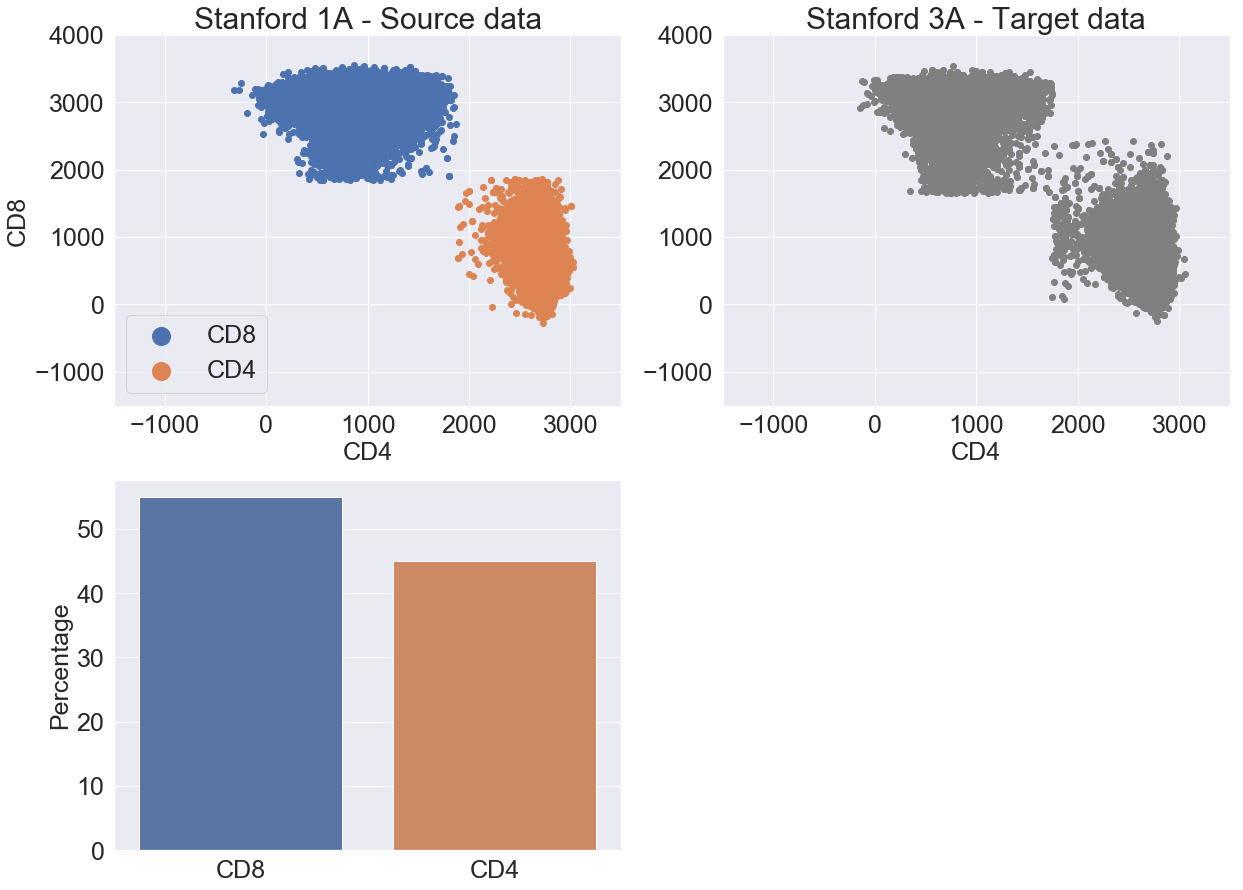

In [11]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
for it in [0,1]:
    plt.scatter(X_source[Lab_source==it,0], X_source[Lab_source==it,1],
               label=names_pop[it])
plt.xlabel('CD4', size=25)
plt.ylabel('CD8', size=25)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
plt.title('Stanford 1A - Source data', size=30)


plt.subplot(2,2,2)
plt.scatter(X_target[:,0], X_target[:,1], c='grey')
plt.xlabel('CD4', size=25)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Stanford 3A - Target data', size=30)

plt.subplot(2,2,3)
sns.barplot(x=names_pop, y=100*h_source)
plt.ylabel('Percentage', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);


## Classification using optimal transport

##### without reweighting

In [16]:
I = X_source.shape[0]
J = X_target.shape[0]

alpha = 1/I * np.ones(I)
beta = 1/J * np.ones(J)

# Preprocessing of the data

X_source = X_source * (X_source > 0)
X_target = X_target * (X_target > 0)

scaler = MinMaxScaler()
X_source = scaler.fit_transform(X_source)
X_target = scaler.fit_transform(X_target)

##### Approximation of the optimal dual vector u.

In order to compute an approximation of the optimal transportation plan, we need to approximate $P_{\varepsilon}$.

In [17]:
eps = 0.02
n_iter = 150000

t0 = time.time()
Res_RM = Robbins_Monro_Algo(X_source, X_target, alpha, beta, eps=eps, n_iter=n_iter)
elapsed_time = time.time() - t0

u_last = Res_RM[0]
W_hat = Res_RM[1]
Sig_hat = Res_RM[2]

In [18]:
print('Elapsed time :', elapsed_time/60, 'mins')

Elapsed time : 5.571855517228444 mins


##### Label propagation

In [19]:
L_source = np.zeros((2,I))
for k in range(2):
    L_source[k] = np.asarray(Lab_source == k, dtype = int)
    
t0 = time.time()
Result_LP = Label_Prop_sto(L_source, u_last, X_source, X_target, alpha, beta, eps)
elapsed_time = time.time()-t0
Lab_target_hat_one = Result_LP[1]

[3.19060685e-05 3.19060685e-05 3.19060685e-05 ... 3.19060685e-05
 3.19060685e-05 3.19060685e-05]
Computation of ctransform done.


In [20]:
print('Elapsed_time ', elapsed_time/60, 'mins')

Elapsed_time  1.1653838713963827 mins


In [21]:
X_tar_display = np.asarray(Stanford3A_values[['CD4', 'CD8']])

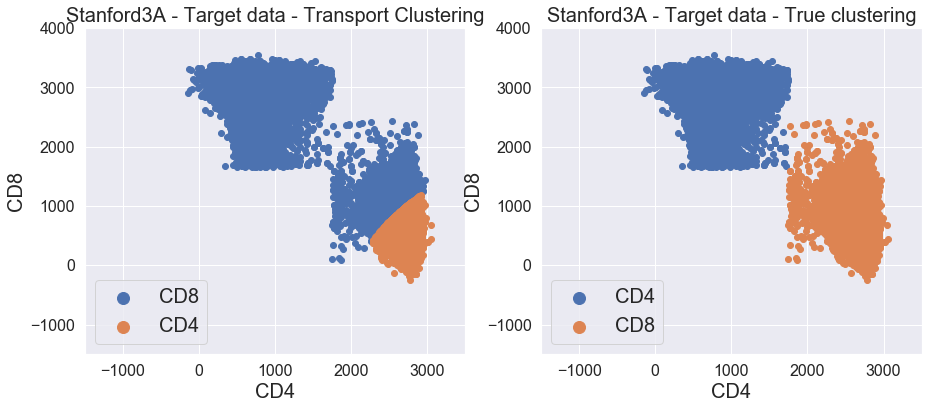

In [22]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
for it in [1,2]:
    plt.scatter(X_tar_display[Lab_target_hat_one==it,0],
                X_tar_display[Lab_target_hat_one==it,1],
               label=names_pop[it-1])
plt.xlabel('CD4', size=20)
plt.ylabel('CD8', size=20)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20, markerscale=2)
plt.title('Stanford3A - Target data - Transport Clustering', size=20)


plt.subplot(1,2,2)
for it in [0,1]:
    plt.scatter(X_tar_display[Lab_target==it,0],
                X_tar_display[Lab_target==it,1],
               label=names_pop[it-1])
plt.xlabel('CD4', size=20)
plt.ylabel('CD8', size=20)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20, markerscale=2)
plt.title('Stanford3A - Target data - True clustering', size=20);

## Class proportions estimation with ${\tt CytOpt}$


### Descent-Ascent procedure

##### Setting of the parameters

In [23]:
n_it_grad = 10000
n_it_sto = 10
pas_grad = 1
eps=0.0005

In [24]:
t0 = time.time()
h_hat = cytopt_desas(n_it_grad=n_it_grad, X=X_source, Lab_source=Lab_source, 
                              Y=X_target, n_it_sto=n_it_sto, step_grad=pas_grad, eps=eps)

elapsed_time = time.time()-t0

Iteration  0
Curent h_hat
[0.49948325 0.50051675]
Iteration  1000
Curent h_hat
[0.40794677 0.59205323]
Iteration  2000
Curent h_hat
[0.35934197 0.64065803]
Iteration  3000
Curent h_hat
[0.32586046 0.67413954]
Iteration  4000
Curent h_hat
[0.30784307 0.69215693]
Iteration  5000
Curent h_hat
[0.29067976 0.70932024]
Iteration  6000
Curent h_hat
[0.27919426 0.72080574]
Iteration  7000
Curent h_hat
[0.27348493 0.72651507]
Iteration  8000
Curent h_hat
[0.2687042 0.7312958]
Iteration  9000
Curent h_hat
[0.25616201 0.74383799]


In [25]:
print('Elapsed time:', elapsed_time/60, 'mins')

Elapsed time: 12.583130407333375 mins


##### ${\tt CytOpt}$ estimation and benchmark estimation

In [26]:
print('Estimated proportions', h_hat)
print('Benchmark proportions', h_true)

Estimated proportions [0.26665629 0.73334371]
Benchmark proportions [0.26079666 0.73920334]


### Display of the estimation Results

In [27]:
pourcentage = np.hstack((h_true, h_hat))
cell_type = np.tile(['CD8', 'CD4'], 2)
method = np.repeat(['Manual benchmark', 'Transport estimation'], 2)

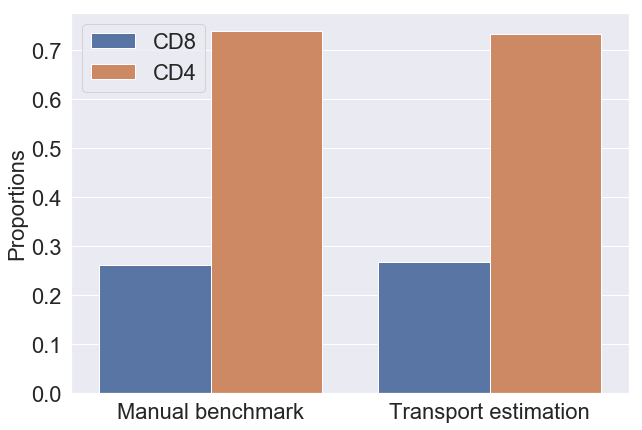

In [28]:
Res_df = pd.DataFrame({'Pourcentage': pourcentage, 'Type_cellule' : cell_type, 'Methode' : method})

plt.figure(figsize=(10,7))
sns.barplot(x='Methode', y='Pourcentage', hue='Type_cellule', data=Res_df)
plt.legend(fontsize=22)
plt.ylabel('Proportions', size=22)
plt.xlabel('')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22);

### Minmax swapping procedure

##### Setting of the parameters

In [29]:
lbd = 0.0001
eps_two = 0.0001
n_iter = 10000
step_size = 5
power = 0.99

In [30]:
t0 = time.time()
results = cytopt_minmax_monitor(lbd, eps_two, X_source, X_target, Lab_source, n_iter,
                            h_true, step=step_size, power=power)
elapsed_time = time.time() - t0

In [31]:
print('Elapsed time : ',elapsed_time/60, 'Mins')

Elapsed time :  1.1802414933840433 Mins


In [32]:
h_hat2 = results[0]
print(h_hat2)

[0.25618596 0.74381404]


### Comparison of the two minimization procedures

In [33]:
Proportion = np.hstack((h_hat, h_hat2, h_true))
Classes = np.tile(np.arange(1,3),3)
Methode = np.repeat(['CytOpt_DesAsc', 'CytOpt_Minmax', 'Manual'], 2)
df_res1 = pd.DataFrame({'Proportions':Proportion, 'Classes':Classes, 'Methode':Methode})

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 <a list of 9 Text yticklabel objects>)

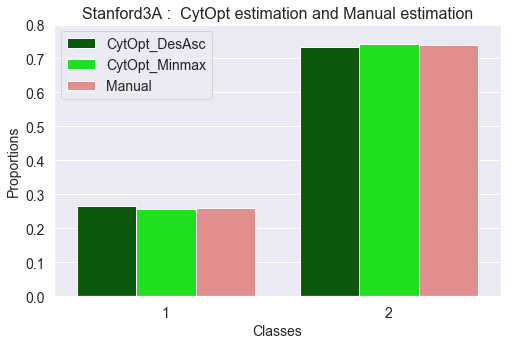

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x='Classes', y='Proportions', hue='Methode', data=df_res1,
           palette=['darkgreen', 'lime', 'lightcoral'])
plt.title('Stanford3A :  CytOpt estimation and Manual estimation', size=16)
plt.legend(loc = 'upper left', fontsize=14)
plt.xlabel('Classes', size=14)
plt.ylabel('Proportions', size=14)
plt.ylim(0,0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('Barplot_Stan3C_prepocessing.eps', format='eps')

### Classification using optimal transport with reweighted proportions

#### The target measure $\beta$ is reweighted in order to match the weight vector $\hat{h}$ estimated with ${\tt CytOpt}$.

In [35]:
D = np.zeros((I,2))
D[:,0] = 1/np.sum(Lab_source == 0) * np.asarray(Lab_source == 0, dtype=float)
D[:,1] = 1/np.sum(Lab_source == 1) * np.asarray(Lab_source == 1, dtype=float)
alpha_mod = D.dot(h_hat)

##### Approximation of the optimal dual vector u.

In [36]:
eps = 0.02
n_iter = 150000

t0 = time.time()
Res_RM2 = Robbins_Monro_Algo(X_source, X_target, alpha_mod, beta, eps=eps, n_iter=n_iter)
elapsed_time = time.time() - t0

u_last_two = Res_RM2[0]
W_hat = Res_RM2[1]
Sig_hat = Res_RM2[2]

In [37]:
print('Elapsed time :', elapsed_time/60, 'mins')

Elapsed time : 5.631325896581014 mins


#### Label propogation

In [38]:
t0 = time.time()
Result_LP = Label_Prop_sto(L_source, u_last_two, X_source, X_target, alpha_mod, beta, eps)
elapsed_time = time.time()-t0
Lab_target_hat_two = Result_LP[1]

[1.54906638e-05 1.54906638e-05 1.54906638e-05 ... 5.19071145e-05
 5.19071145e-05 5.19071145e-05]
Computation of ctransform done.


In [39]:
print('Elapsed time', elapsed_time/60, 'mins')

Elapsed time 1.2009437918663024 mins


### Display of the label transfer results without or with reweighting.

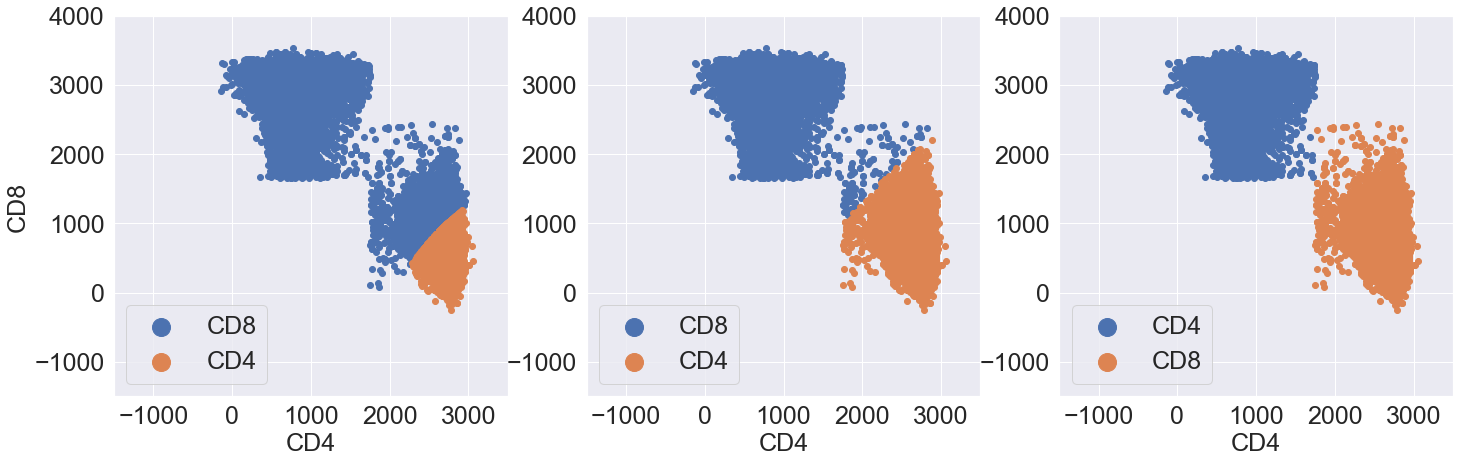

In [40]:
plt.figure(figsize=(24,7))
#plt.suptitle('Target Data : CIMR3A', size=25)

plt.subplot(1,3,1)
for it in [1,2]:
    plt.scatter(X_tar_display[Lab_target_hat_one==it,0],
                X_tar_display[Lab_target_hat_one==it,1],
               label=names_pop[it-1])
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.ylabel('CD8', size=25)
plt.xlabel('CD4', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
#plt.title('Transport clustering without re weighting', size=25)


plt.subplot(1,3,2)
for it in [1,2]:
    plt.scatter(X_tar_display[Lab_target_hat_two==it,0],
                X_tar_display[Lab_target_hat_two==it,1],
               label=names_pop[it-1])
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xlabel('CD4', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
#plt.title('Transport clustering with re weighting', size=25)


plt.subplot(1,3,3)
for it in [0,1]:
    plt.scatter(X_tar_display[Lab_target==it,0],
                X_tar_display[Lab_target==it,1],
               label=names_pop[it-1])
#plt.text(-5000, -2200, 'CD4', ha='center', size = 25)
#plt.text(-14500, 1400, 'CD8', va='center', rotation='vertical', size = 25)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xlabel('CD4', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
#plt.title('Manual gating', size=25)
#plt.savefig(fname ='Transfert_CD48_Article.jpeg', format='jpeg', dpi=350);

### Transportation plan with or without reweighting

##### Without reweighting

In [41]:
n_sub = 500
eps = 0.02

source_indices = np.random.choice(I, size=n_sub, replace = False)
u_ce_storage = np.zeros(J)
for j in range(J):
    u_ce_storage[j] = c_transform(u_last, X_source, X_target, j, beta)

In [42]:
indices = np.zeros((n_sub,2))
for k,it in enumerate(source_indices):
    indices[k,0]=it
    cost_x = cost(X_target, X_source[it])
    arg = np.exp((u_last[it]+ u_ce_storage - cost_x)/eps)
    indices[k,1]=np.argmax(arg)

In [43]:
indices = np.asarray(indices, dtype=int)

##### with reweighting

In [44]:
u_ce_storage_two = np.zeros(J)
for j in range(J):
    u_ce_storage_two[j] = c_transform(u_last_two, X_source, X_target, j, beta)

In [45]:
indices_two = np.zeros((n_sub,2))
for k,it in enumerate(source_indices):
    indices_two[k,0]=it
    cost_x = cost(X_target, X_source[it])
    arg = np.exp((u_last_two[it]+ u_ce_storage_two - cost_x)/eps)
    indices_two[k,1]=np.argmax(arg)

In [46]:
indices_two = np.asarray(indices_two, dtype=int)

In [47]:
X_target_lag = X_tar_display.copy()
X_target_lag[:,0] = X_target_lag[:,0] + 3500

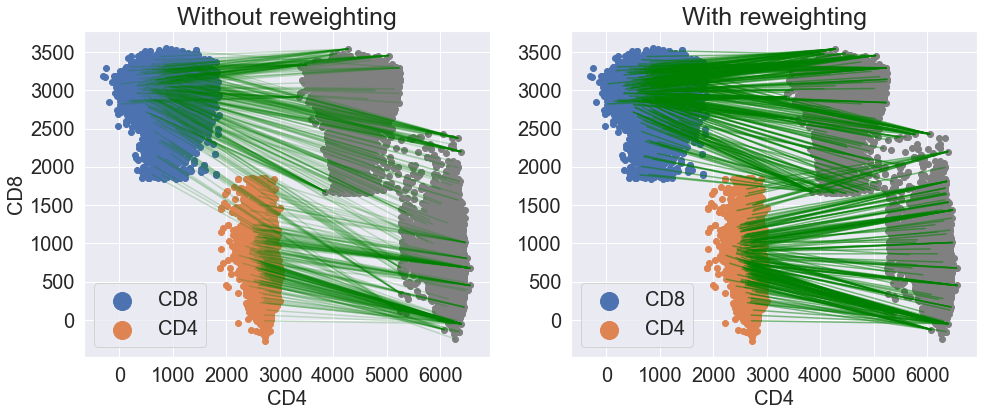

In [48]:
plt.figure(figsize=(16,6))
#plt.suptitle('Source : Stanford1A - Target : CIMR3A', size=20)
plt.subplot(1,2,1)
for it in [0,1]:
    plt.scatter(X_sou_display[:,0][Lab_source==it],
                X_sou_display[:,1][Lab_source==it],
               label=names_pop[it])

plt.scatter(X_target_lag[:,0], X_target_lag[:,1], c='grey')
for i in range(n_sub):
    plt.plot([X_sou_display[indices[i,0], 0], X_target_lag[indices[i,1],0]],
            [X_sou_display[indices[i,0], 1], X_target_lag[indices[i,1],1]],
            c='green', alpha = 0.2)
plt.title('Without reweighting', size=25)
plt.xlabel('CD4', size=20)
plt.ylabel('CD8', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=20, markerscale=3)


plt.subplot(1,2,2)
for it in [0,1]:
    plt.scatter(X_sou_display[:,0][Lab_source==it],
                X_sou_display[:,1][Lab_source==it],
               label=names_pop[it])
    
plt.scatter(X_target_lag[:,0], X_target_lag[:,1], c='grey')
for i in range(n_sub):
    plt.plot([X_sou_display[indices_two[i,0], 0], X_target_lag[indices_two[i,1],0]],
            [X_sou_display[indices_two[i,0], 1], X_target_lag[indices_two[i,1],1]],
            c='green', alpha = 0.5)
plt.title('With reweighting', size=25)
plt.xlabel('CD4', size=20)
#plt.ylabel('CD8', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=20, markerscale=3)

#plt.savefig(fname ='Transport_Plan_CD4_CD8.jpeg', format='jpeg', dpi=350)

### Approximation of the function $F : h \mapsto W^{\varepsilon}(\alpha(h), \beta)$

In [49]:
n_h_grid = 40

h_grid = np.linspace(0.1, 0.5, n_h_grid)
W_func_h = np.zeros(n_h_grid)

Warning : we approximate forty distinct Wasserstein distance, it may last up to one hour.

In [50]:
eps = 0.001
n_iter = 30000
t0 = time.time()

for it, h in enumerate(h_grid):
    alpha_mod = D.dot(np.asarray([h,1-h]))
    Res_RM = Robbins_Monro_Algo(X_source, X_target, alpha_mod, beta, eps=eps, n_iter=n_iter)
    W_func_h[it] = Res_RM[1][-1]
    print([h,1-h])
    print(W_func_h[it])

elapsed_time = time.time() - t0

[0.1, 0.9]
-0.1398505524447691
[0.11025641025641027, 0.8897435897435897]
-0.1396574521208614
[0.12051282051282051, 0.8794871794871795]
-0.14046316750397636
[0.13076923076923078, 0.8692307692307693]
-0.14217647438620754
[0.14102564102564102, 0.858974358974359]
-0.14664752329365904
[0.1512820512820513, 0.8487179487179487]
-0.1462453587435277
[0.16153846153846155, 0.8384615384615385]
-0.14573509825718683
[0.1717948717948718, 0.8282051282051281]
-0.14651723548455958
[0.18205128205128207, 0.8179487179487179]
-0.14867995738572468
[0.19230769230769232, 0.8076923076923077]
-0.14904588003965533
[0.20256410256410257, 0.7974358974358975]
-0.14922355977869842
[0.21282051282051284, 0.7871794871794872]
-0.14793552373755925
[0.2230769230769231, 0.7769230769230769]
-0.1524190666029967
[0.23333333333333334, 0.7666666666666666]
-0.15071830084876842
[0.24358974358974358, 0.7564102564102564]
-0.15033908317720027
[0.25384615384615383, 0.7461538461538462]
-0.15232311120173536
[0.2641025641025641, 0.73589743

In [51]:
print('Elapsed Time : ', elapsed_time/60, ' mins')

Elapsed Time :  54.58130744298299  mins


(array([-0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12]),
 <a list of 7 Text yticklabel objects>)

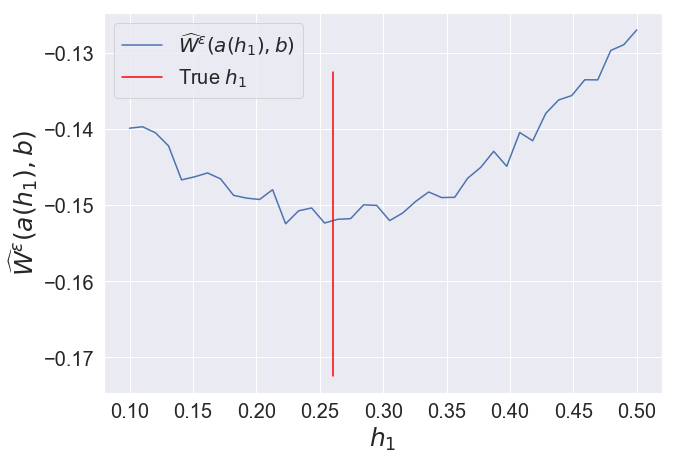

In [52]:
plt.figure(figsize=(10,7))
plt.plot(h_grid, W_func_h, label = r'$\widehat{W}^{\varepsilon}(a(h_1),b)$')
plt.plot([h_true[0], h_true[0]], [W_func_h.min()-0.02, W_func_h.min()+0.02], c='red', label = r'True $h_1$')
plt.legend(loc='best', fontsize=20, markerscale=2)
#plt.title('Wasserstein regularized distance', size=30)
plt.xlabel(r'$h_1$', size=25)
plt.ylabel(r'$\widehat{W}^{\varepsilon}(a(h_1),b)$', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig(fname ='Wass_function_of_h.eps', format='eps')